In [1]:
%load_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import time
import json
import glob
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [3]:
import sys
sys.path.append('../')
from fog_dataloader import FogDataloader as fog
from models import multiview_vit as vit
from utils import SparkMET as sm
from utils import engine
import torch
device = "cuda:2" if torch.cuda.is_available() else "cpu"
print(f"Check if there is GPU(s): {torch.cuda.is_available()}")

Check if there is GPU(s): True


### PIT_V2

In [5]:
Th_v2 = 0.5710000000000001

In [6]:
test_df = pd.read_csv('/data1/fog/Hamid/SparkMET/EXPs/PIT_V2_BCE_0001_01_30_256/test_prob_PIT_V2_BCE_0001_01_30_256.csv', index_col= 0)
test_df.head(5)

,date_time,round_time,date_cycletime,vis,ytrue,fog_prob,nonfog_prob
0,20180530 05:55:00,20180530 06:00:00,20180530_0000,10.0,0,0.000072,0.999928
1,20180530 11:55:00,20180530 12:00:00,20180530_0600,10.0,0,0.000141,0.999859
2,20180530 17:55:00,20180530 18:00:00,20180530_1200,10.0,0,0.000042,0.999958
3,20180530 23:55:00,20180531 00:00:00,20180530_1800,10.0,0,0.000132,0.999868
4,20180531 05:55:00,20180531 06:00:00,20180531_0000,10.0,0,0.000074,0.999926


In [7]:
def categorize(row):
    if row['ytrue'] == 1 and row['fog_prob'] > Th_v2:
        return 'Hit'
    elif row['ytrue'] == 1 and row['fog_prob'] <= Th_v2:
        return 'Miss'
    elif row['ytrue'] == 0 and row['fog_prob'] > Th_v2:
        return 'FA'
    elif row['ytrue'] == 0 and row['fog_prob'] <= Th_v2:
        return 'CR'

test_df['category'] = test_df.apply(categorize, axis=1)
test_df

,date_time,round_time,date_cycletime,vis,ytrue,fog_prob,nonfog_prob,category
0,20180530 05:55:00,20180530 06:00:00,20180530_0000,10.0,0,0.000072,0.999928,CR
1,20180530 11:55:00,20180530 12:00:00,20180530_0600,10.0,0,0.000141,0.999859,CR
2,20180530 17:55:00,20180530 18:00:00,20180530_1200,10.0,0,0.000042,0.999958,CR
3,20180530 23:55:00,20180531 00:00:00,20180530_1800,10.0,0,0.000132,0.999868,CR
4,20180531 05:55:00,20180531 06:00:00,20180531_0000,10.0,0,0.000074,0.999926,CR
...,...,...,...,...,...,...,...,...
2223,20200527 23:55:00,20200528 00:00:00,20200527_1800,10.0,0,0.000087,0.999912,CR
2224,20200529 05:55:00,20200529 06:00:00,20200529_0000,10.0,0,0.000910,0.999090,CR
2225,20200529 11:55:00,20200529 12:00:00,20200529_0600,10.0,0,0.002007,0.997993,CR
2226,20200529 17:55:00,20200529 18:00:00,20200529_1200,10.0,0,0.000503,0.999497,CR


In [27]:
test_df['date_time'] = pd.to_datetime(test_df['date_time'])
test_df['day_of_year'] = test_df['date_time'].dt.dayofyear

In [45]:
custom_x_labels

['Jan\nFA: 4 Hit: 7 Miss: 5',
 'Feb\nFA: 11 Hit: 13 Miss: 8',
 'Mar\nFA: 17 Hit: 12 Miss: 3',
 'Apr\nFA: 10 Hit: 9 Miss: 1',
 'Oct\nFA: 0 Hit: 0 Miss: 1',
 'Nov\nFA: 7 Hit: 0 Miss: 4',
 'Dec\nFA: 0 Hit: 0 Miss: 4']

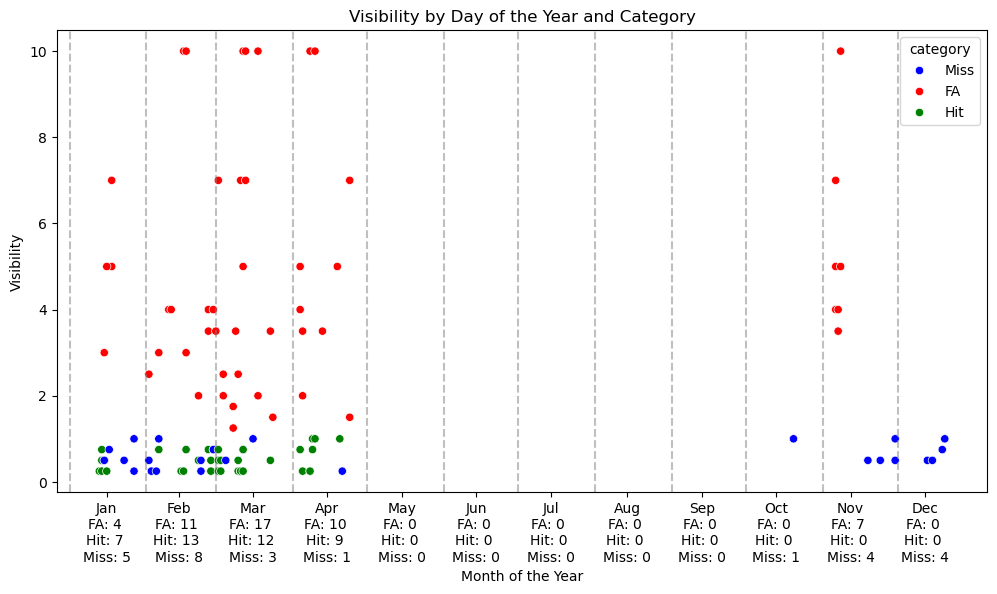

In [58]:
palette = {'Hit': 'green', 'Miss': 'blue', 'FA': 'red', 'CR': 'gray'}
month_labels = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
month_middle = [16, 45, 75, 105, 135, 165, 195, 226, 256, 286, 316, 346]

df_filtered = test_df[test_df['category'] != 'CR']

category_counts = df_filtered['category'].value_counts()
monthly_category_counts = df_filtered.groupby([df_filtered['date_time'].dt.month, 'category']).size().unstack(fill_value=0)

custom_x_labels = []
for month in range(1, 13):
    label = month_labels[month - 1] + "\n"
    if month in monthly_category_counts.index.values:
        for category in monthly_category_counts.columns:
            label += f"{category}: {monthly_category_counts.at[month, category]} \n"
    else: 
        label += f"FA: 0 \nHit: 0 \nMiss: 0"
    custom_x_labels.append(label.strip())



plt.figure(figsize=(12, 6))
sns.scatterplot(data=df_filtered, x='day_of_year', y='vis', hue='category', palette=palette)


# Adding vertical lines for each month
months = [1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]  # Approximate start of each month
for month in months:
    plt.axvline(x=month, color='grey', linestyle='--', alpha=0.5)

plt.xticks(month_middle, custom_x_labels, rotation=0)


plt.xlabel('Month of the Year')
plt.ylabel('Visibility')
plt.title('Visibility by Day of the Year and Category')
plt.show()

In [8]:
hit_cases = test_df[(test_df['fog_prob'] > Th_v2) & (test_df['ytrue'] == 1)]
miss_cases = test_df[(test_df['fog_prob'] < Th_v2) & (test_df['ytrue'] == 1)]
fa_cases = test_df[(test_df['fog_prob'] > Th_v2) & (test_df['ytrue'] == 0)]

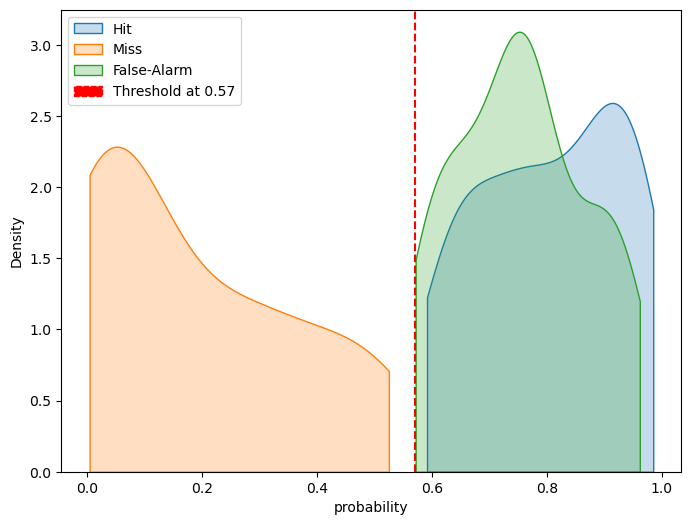

In [25]:
fig, axs = plt.subplots(1, 1, figsize = (8, 6))

combined_df = pd.DataFrame({
    'probability': pd.concat([hit_cases['fog_prob'], miss_cases['fog_prob'], fa_cases['fog_prob']]),
    'Category': ['Hit'] * len(hit_cases) + ['Miss'] * len(miss_cases) + ['False-Alarm'] * len(fa_cases)
})

# Plotting KDE plots on the specified axes
for category in combined_df['Category'].unique():
    sns.kdeplot(data=combined_df[combined_df['Category'] == category], x='probability', cut = 0, fill=True, ax=axs, label=category)
# sns.histplot(data=combined_df, x="probability", hue="Category", ax=axs, bins=30, kde=False)

axs.axvline(x=0.57, color='red', linestyle='--')
red_line = mpatches.Patch(color='red', linestyle='--', label='Threshold at 0.57')
handles, labels = axs.get_legend_handles_labels()
handles.append(red_line) 
# Adjust the legend to the top left corner
axs.legend(handles=handles, loc='upper left')
plt.show()

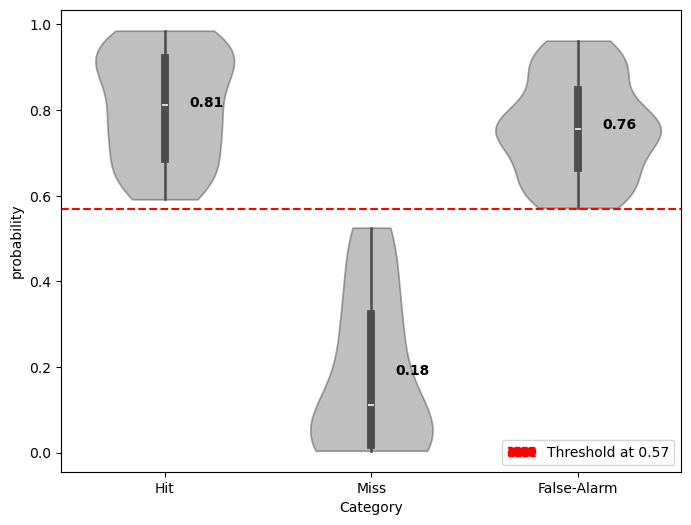

In [29]:
fig, axs = plt.subplots(1, 1, figsize=(8, 6))

category_colors = {'Hit': 'blue', 'Miss': 'green', 'False-Alarm': 'orange'}

# Plotting violin plot with custom colors
sns.violinplot(data=combined_df, x='Category', y='probability', ax=axs, color='gray', alpha=0.5, cut=0) 
# sns.stripplot(data=combined_df, x='Category', y='probability', ax=axs, palette=category_colors, jitter = True)

# Calculate and display mean values
categories = combined_df['Category'].unique()
for i, category in enumerate(categories):
    mean_val = combined_df[combined_df['Category'] == category]['probability'].mean()
    # Adjusting x position slightly to the right
    axs.text(i + 0.2, mean_val, f'{mean_val:.2f}', horizontalalignment='center', color='black', weight='semibold')


# Adding horizontal line
axs.axhline(y=0.57, color='red', linestyle='--')

# Creating custom handles for the legend (for the categories and the horizontal line)
# category_handles = [mpatches.Patch(color=color, label=cat) for cat, color in category_colors.items()]
threshold_line = mpatches.Patch(color='red', linestyle='--', label='Threshold at 0.57')
handles =[threshold_line]

# Adding legend to the plot
axs.legend(handles=handles, loc='lower right')

plt.show()

### Ensemble

In [36]:
vvt = '00_VVT_BCE_0001_01_30_32'
# uvt = '01_UVT_BCE_0001_01_20_32'
svt = '03_SVT_BCE_0001_01_20_128_init'
pit1 = '04_PIT_V1_BCE_0001_01_30_128'
pit2 = '05_PIT_V2_BCE_0001_01_30_256'

list_exp = [vvt, svt, pit1, pit2]

In [37]:
root_dir = '/data1/fog/Hamid/SparkMET/EXPs/' 

In [38]:
train_fog_means, test_fog_means = [], []
train_dfs, test_dfs = [], []

for ex in list_exp:
    train_name = 'train_prob_' + ex + '.csv'
    dir = os.path.join(root_dir, ex, train_name)
    train_df = pd.read_csv(dir)
    train_dfs.append(train_df)

    test_name = 'test_prob_' + ex + '.csv'
    dir2 = os.path.join(root_dir, ex, test_name)
    test_df = pd.read_csv(dir2)
    test_dfs.append(test_df) 


train_concat = pd.concat(train_dfs)
test_concat = pd.concat(test_dfs)

# Calculate mean across all dataframes
train_mean = train_concat.groupby(train_concat.index).mean()[['fog_prob', 'nonfog_prob']]
test_mean = test_concat.groupby(test_concat.index).mean()[['fog_prob', 'nonfog_prob']]

# Adding back the 'id' column
train_mean['date_time'] = train_dfs[0]['date_time']
test_mean['date_time'] = test_dfs[0]['date_time']

In [46]:
pd.read_csv('/data1/fog/Hamid/SparkMET/EXPs/00_VVT_BCE_0001_01_30_32/train_prob_00_VVT_BCE_0001_01_30_32.csv')

,Unnamed: 0,date_time,round_time,date_cycletime,vis,ytrue,fog_prob,nonfog_prob
0,0,20160222 05:55:00,20160222 06:00:00,20160222_0000,3.0,0,2.465479e-01,0.753452
1,1,20120516 11:55:00,20120516 12:00:00,20120516_0600,10.0,0,3.830819e-04,0.999617
2,2,20100124 12:00:00,20100124 12:00:00,20100124_0600,10.0,0,1.066049e-04,0.999893
3,3,20100901 12:05:00,20100901 12:00:00,20100901_0600,10.0,0,4.535200e-07,1.000000
4,4,20140528 17:55:00,20140528 18:00:00,20140528_1200,10.0,0,1.978982e-05,0.999980
...,...,...,...,...,...,...,...,...
7955,7955,20120302 23:55:00,20120303 00:00:00,20120302_1800,5.0,0,1.447438e-03,0.998552
7956,7956,20150722 11:55:00,20150722 12:00:00,20150722_0600,7.0,0,9.469758e-07,0.999999
7957,7957,20101002 06:05:00,20101002 06:00:00,20101002_0000,10.0,0,5.060221e-07,1.000000
7958,7958,20131202 23:55:00,20131203 00:00:00,20131202_1800,10.0,0,1.403773e-04,0.999860


In [50]:
def calculate_cellwise_means(root_dir, list_exp):
    train_dfs, test_dfs = [], []

    for ex in list_exp:
        # Reading train dataframe
        train_name = 'train_prob_' + ex + '.csv'
        train_dir = os.path.join(root_dir, ex, train_name)
        train_df = pd.read_csv(train_dir).sort_values(by='date_time')
        train_dfs.append(train_df)

        # Reading test dataframe
        test_name = 'test_prob_' + ex + '.csv'
        test_dir = os.path.join(root_dir, ex, test_name)
        test_df = pd.read_csv(test_dir).sort_values(by='date_time')
        test_dfs.append(test_df)

    # Concatenate all train and test dataframes
    train_concat = pd.concat(train_dfs).sort_values(by='date_time')
    test_concat = pd.concat(test_dfs).sort_values(by='date_time')

    # Calculate mean across all dataframes
    train_mean = train_concat.groupby(train_concat['date_time']).mean()[['fog_prob', 'nonfog_prob']]
    test_mean = test_concat.groupby(test_concat['date_time']).mean()[['fog_prob', 'nonfog_prob']]

    # Adding back the 'date_time' and 'class_label' columns
    train_mean['date_time'] = train_mean.index
    train_mean['round_time'] = train_dfs[0]['round_time'].values
    train_mean['date_cycletime'] = train_dfs[0]['date_cycletime'].values
    train_mean['vis'] = train_dfs[0]['vis'].values
    train_mean['ytrue'] = train_dfs[0]['ytrue'].values


    test_mean['date_time'] = test_mean.index
    test_mean['round_time'] = test_dfs[0]['round_time'].values
    test_mean['date_cycletime'] = test_dfs[0]['date_cycletime'].values
    test_mean['vis'] = test_dfs[0]['vis'].values
    test_mean['ytrue'] = test_dfs[0]['ytrue'].values

    return train_mean, test_mean

# Use the function
root_dir = '/data1/fog/Hamid/SparkMET/EXPs/'  
list_exp = [vvt, svt, pit1, pit2]
train_mean, test_mean = calculate_cellwise_means(root_dir, list_exp)

In [51]:
train_mean

,fog_prob,nonfog_prob,date_time,round_time,date_cycletime,vis,ytrue
date_time,,,,,,,
20090102 06:05:00,0.210847,0.789153,20090102 06:05:00,20090102 06:00:00,20090102_0000,7.00,0
20090102 12:05:00,0.695612,0.304389,20090102 12:05:00,20090102 12:00:00,20090102_0600,0.25,1
20090102 18:05:00,0.640756,0.359244,20090102 18:05:00,20090102 18:00:00,20090102_1200,0.25,1
20090103 00:05:00,0.184796,0.815204,20090103 00:05:00,20090103 00:00:00,20090102_1800,4.00,0
20090103 06:05:00,0.426687,0.573313,20090103 06:05:00,20090103 06:00:00,20090103_0000,4.00,0
...,...,...,...,...,...,...,...
20161230 23:55:00,0.000089,0.999911,20161230 23:55:00,20161231 00:00:00,20161230_1800,10.00,0
20161231 05:55:00,0.000434,0.999566,20161231 05:55:00,20161231 06:00:00,20161231_0000,10.00,0
20161231 11:55:00,0.002009,0.997991,20161231 11:55:00,20161231 12:00:00,20161231_0600,10.00,0


In [43]:
test_mean

,fog_prob,nonfog_prob,date_time,ytrue
date_time,,,,
20180530 05:55:00,0.000028,0.999972,20180530 05:55:00,0
20180530 11:55:00,0.000049,0.999951,20180530 11:55:00,0
20180530 17:55:00,0.000017,0.999983,20180530 17:55:00,0
20180530 23:55:00,0.000043,0.999957,20180530 23:55:00,0
20180531 05:55:00,0.000026,0.999974,20180531 05:55:00,0
...,...,...,...,...
20200527 23:55:00,0.000027,0.999973,20200527 23:55:00,0
20200529 05:55:00,0.000345,0.999655,20200529 05:55:00,0
20200529 11:55:00,0.000544,0.999456,20200529 11:55:00,0


In [53]:
report = engine.Evaluation(train_mean, test_mean, by = 'HSS', report_file_name = 'ensemble',).return_report()

In [ ]:
engine.Evaluation(train_mean, test_mean, by = 'HSS', report_file_name = 'ensemble',).roc_curve()

TypeError: unsupported operand type(s) for +: 'NoneType' and 'str'

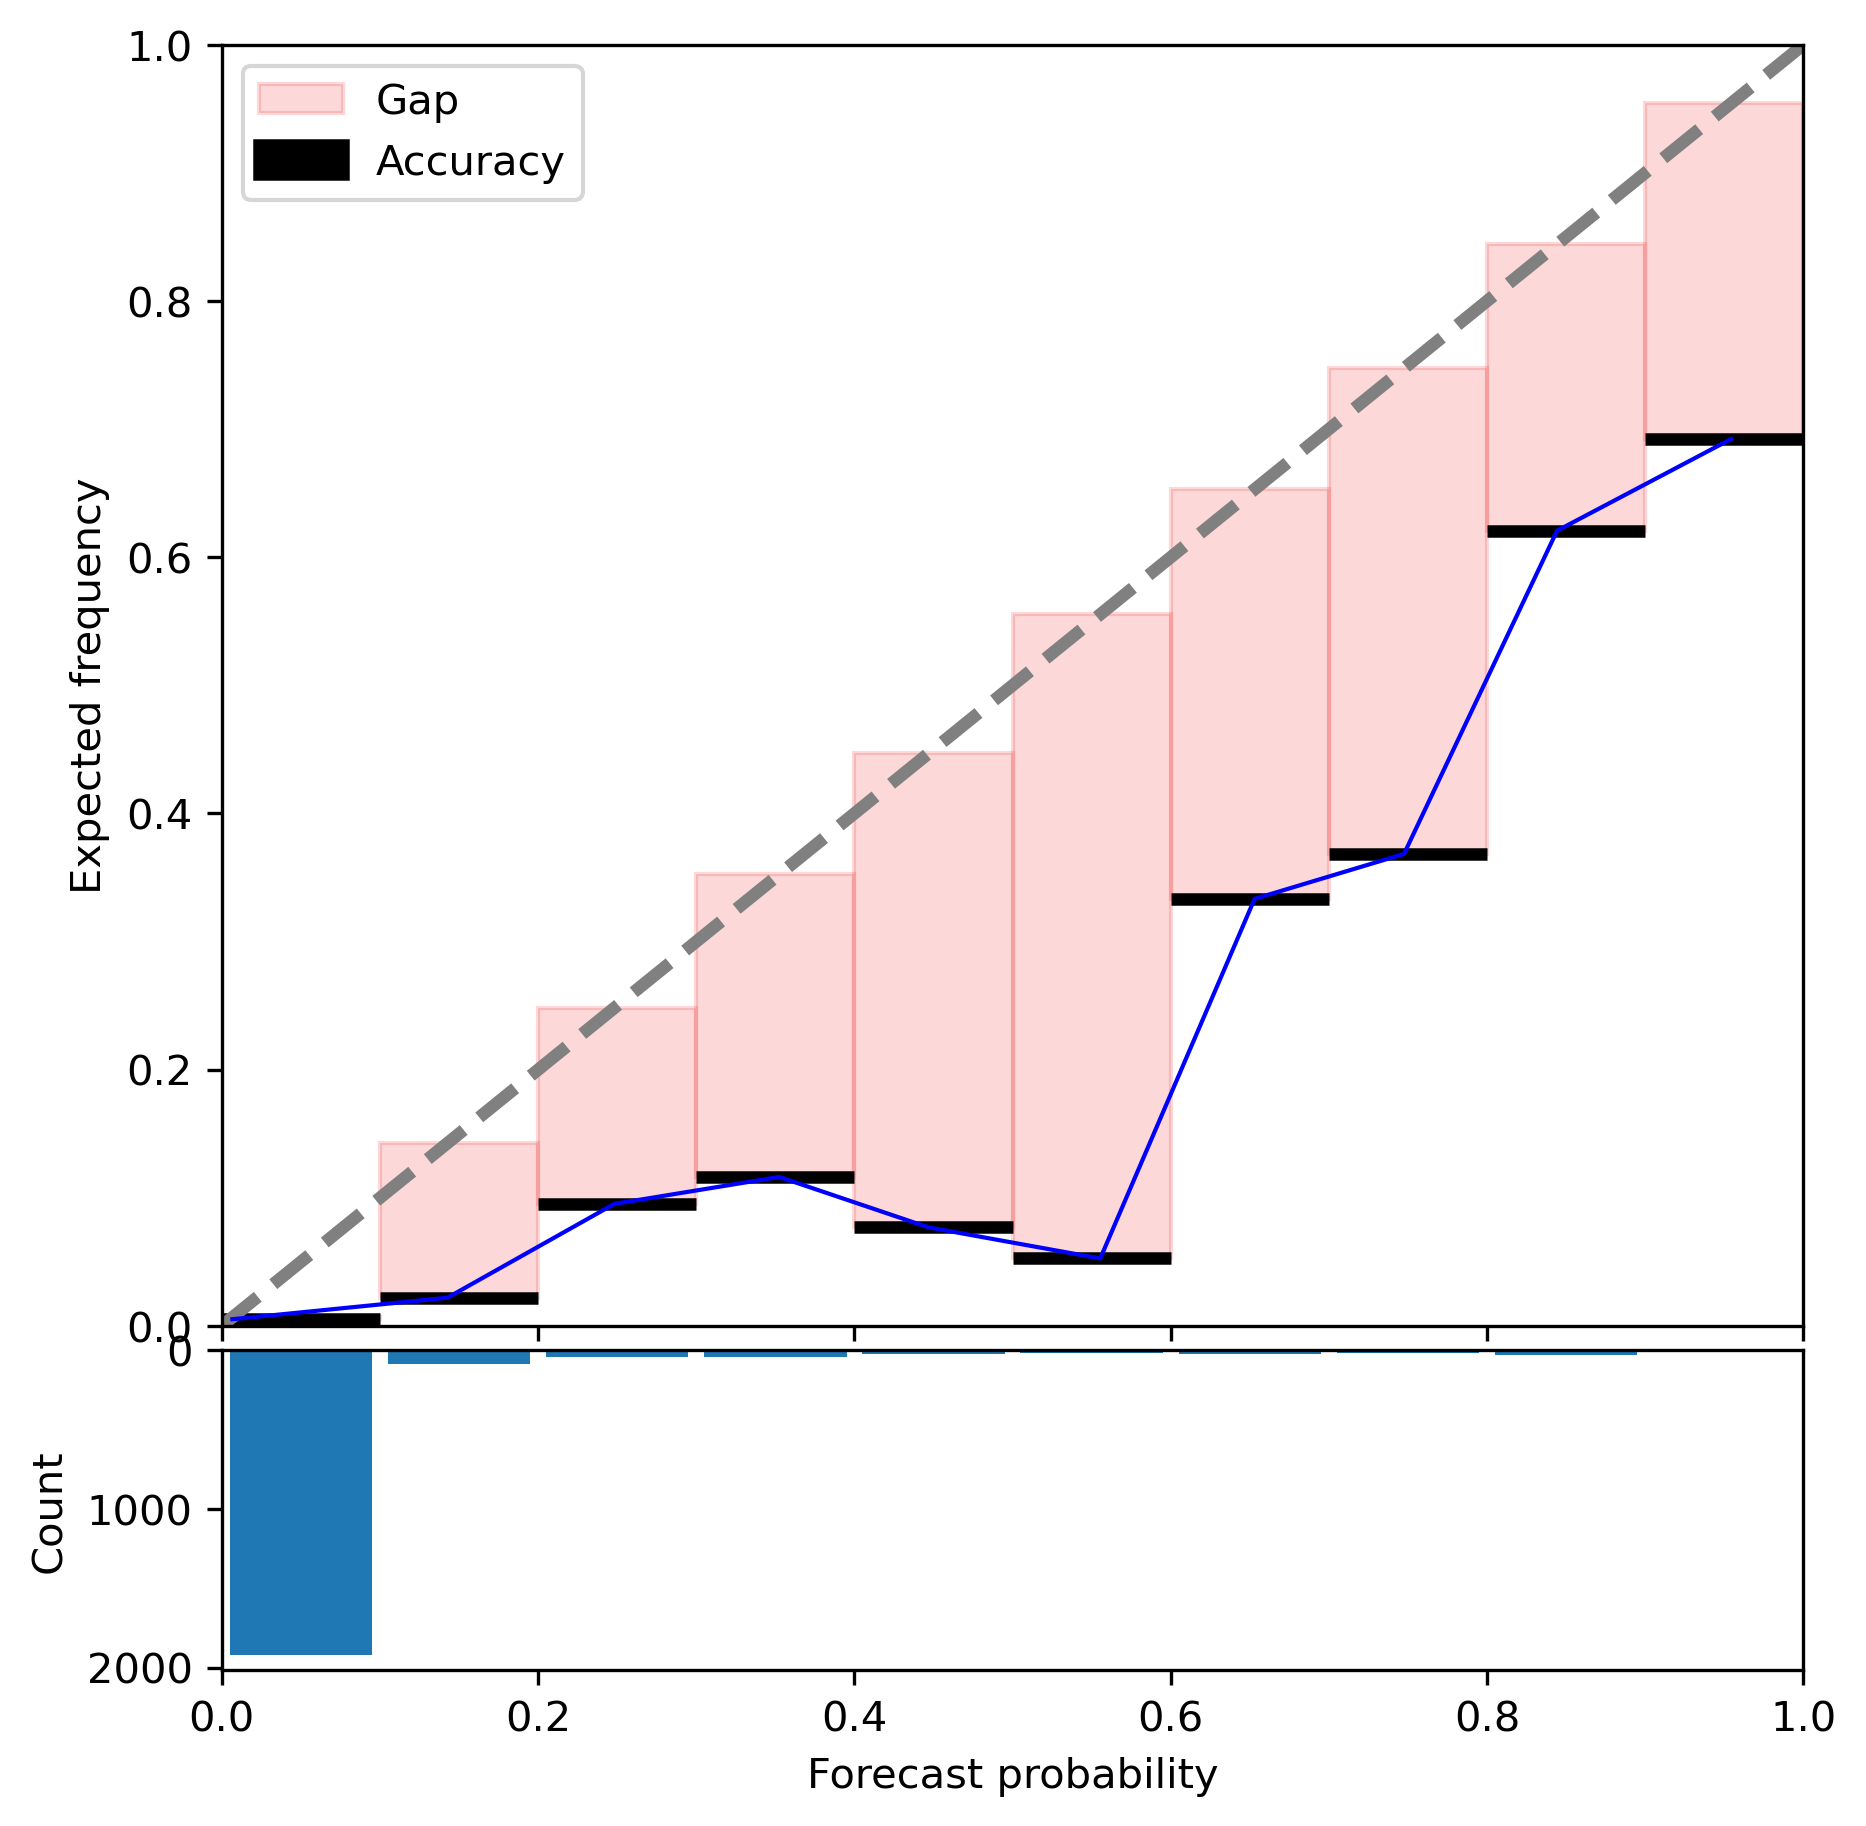

In [55]:
engine.Evaluation(train_mean, test_mean, by = 'HSS', report_file_name = 'ensemble',).reliability_diagram()